# CMS Subtype Distribution by Treatment Status (Pre vs Post)
This notebook visualizes the distribution of CMS subtypes in pretreated and posttreated samples using stacked bar plots.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import chi2_contingency

os.chdir('../../')
os.getcwd()


'd:\\Work\\Non PT\\Data Science\\BG\\mcrc-cetuximab-analysis'

Load the data

In [2]:
df = pd.read_csv("data/ann_with_cms.csv")

## Preprocessing
We ensure time point values are usable for grouping.

In [3]:
# Standardize time point labels
df['time.point'] = df['time.point'].str.lower()

# Check unique time points
df['time.point'].unique()

array(['pre-treatment', 'post-treatment'], dtype=object)

## Calculate CMS subtype distributions for each treatment group

In [4]:
def analyze_cms_distribution(df, group_col='time.point', cms_col='CMS'):
    """
    Analyzes CMS distribution between time points with statistical testing
    
    Returns:
        tuple: (counts_df, percentages_df, stats_dict)
    """
    # Ensure correct ordering
    df[group_col] = pd.Categorical(
        df[group_col],
        categories=['pre-treatment', 'post-treatment'],
        ordered=True
    )

    # Generate counts table
    counts = (
        df.groupby([group_col, cms_col], observed=True)
        .size()
        .unstack(fill_value=0)
    )
    
    # Clean data - drop unclassified if exists
    counts = counts.drop(columns='unclassified', errors='ignore')
    
    # Calculate percentages
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    
    # Statistical testing
    chi2, pval, dof, expected = chi2_contingency(counts)
    n = counts.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(counts.shape) - 1)))
    
    # Prepare results
    stats = {
        'chi2': chi2,
        'p_value': pval,
        'degrees_of_freedom': dof,
        'cramers_v': cramers_v,
        'test_used': 'chi-square',
        'significance': ('*' if pval < 0.05 else 'ns') + 
                       ('*' if pval < 0.01 else '') + 
                       ('*' if pval < 0.001 else '')
    }
    
    # Add Fisher's exact test if needed
    if counts.size == 4 and (counts < 5).any().any():
        from scipy.stats import fisher_exact
        _, pval_fisher = fisher_exact(counts)
        stats.update({
            'fisher_p_value': pval_fisher,
            'test_used': "Fisher's exact"
        })
    
    return counts, percentages.round(1), stats


counts_df, percentages_df, stats = analyze_cms_distribution(df)

print("Counts Table:")
print(counts_df)
print("\nPercentages Table:")
print(percentages_df)
print("\nStatistical Results:")
print(f"χ²({stats['degrees_of_freedom']}) = {stats['chi2']:.2f}, p = {stats['p_value']:.3f}")
print(f"Effect size (Cramer's V) = {stats['cramers_v']:.2f}")
print(f"Significance: {stats['significance']}")

Counts Table:
CMS             CMS1  CMS2  CMS3  CMS4
time.point                            
pre-treatment      6    15     7    20
post-treatment     1     1     2     6

Percentages Table:
CMS             CMS1  CMS2  CMS3  CMS4
time.point                            
pre-treatment   12.5  31.2  14.6  41.7
post-treatment  10.0  10.0  20.0  60.0

Statistical Results:
χ²(3) = 2.17, p = 0.537
Effect size (Cramer's V) = 0.19
Significance: ns


## Plot CMS distribution
We create a horizontal stacked barplot with counts and percentages labeled inside the bars.

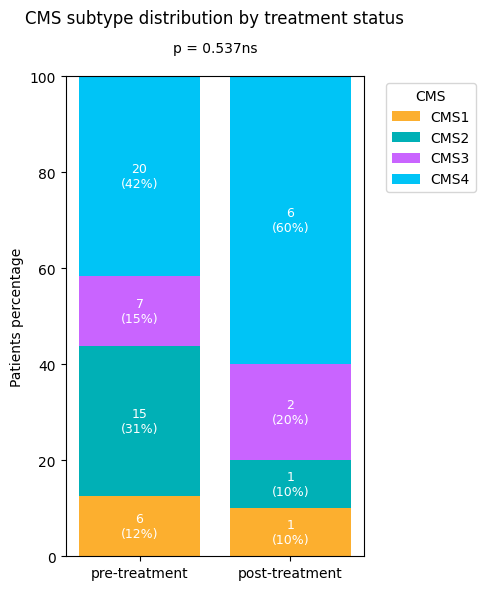

In [5]:
# Define CMS colors
colors = {
    "CMS1": "#FCAF2F",
    "CMS2": "#00B0B6",
    "CMS3": "#C964FF",
    "CMS4": "#00C4F6"
}

# Plot
fig, ax = plt.subplots(figsize=(5, 6))
bottom = pd.Series([0] * len(percentages_df), index=percentages_df.index)

for subtype in percentages_df.columns:
    vals = percentages_df[subtype]
    bar = ax.bar(percentages_df.index, vals, bottom=bottom, label=subtype, color=colors.get(subtype, '#cccccc'))

    for i, (val, btm) in enumerate(zip(vals, bottom)):
        if val > 0:
            count_val = counts_df[subtype].iloc[i]
            ax.text(i, btm + val / 2, f"{count_val}\n({val:.0f}%)", 
                   ha='center', va='center', fontsize=9, color='white')
    bottom += vals

# Add statistical annotation
pval_text = f"p = {stats['p_value']:.3f}{stats['significance']}"
ax.text(0.5, 1.05, pval_text, 
        transform=ax.transAxes, 
        ha='center', 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
        fontsize=10)

ax.set_ylabel("Patients percentage")
ax.set_title("CMS subtype distribution by treatment status\n", y=1.05)  # Adjusted title position
ax.set_ylim(0, 100)
ax.legend(title="CMS", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()